## Investigating Properties of Steady State Measurements vs A3R Measurements

In [1]:
import jax.numpy as jnp
from jax.scipy.special import erf

import matplotlib.pyplot as plt

In [38]:
# Defining all constants

KAPPA = 25.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/2000
GAMMA_MEAS = 1/100
INIT_FID = 1 - 1e-3
SNR_SCALE = 2.3
STATE_STD = 1/jnp.sqrt(2)

### Steady-State Measurements

In [39]:
def SS_meas_pF(
    amp, 
    ts
):
    '''
    Where amp is defined to take values between 0 and 1 like with IBMQ convention
    and ts is a sufficiently large linspace
    returns pF_res with shape (AMPS, TS)
    '''
    amp = amp.reshape(-1, 1)
    ts = ts.reshape(1, -1)
    amp_max = 0.5 * jnp.sqrt(N_MAX * (KAPPA ** 2 + CHI ** 2))
    photon = N_MAX * amp**2
    amp *= amp_max
    separation = (4 * amp * SNR_SCALE / (KAPPA ** 2 + CHI ** 2) 
                  * (CHI * (1. - jnp.exp(-0.5 * KAPPA * ts)) - 0.5 * KAPPA * CHI * ts * jnp.exp(-0.5 * KAPPA * ts)))
    separation_fid = 0.5 * (1. + erf(separation / (2 * jnp.sqrt(2) * STATE_STD)))
    decay_fid = INIT_FID * jnp.exp(-( 
        (GAMMA_PHOTON * photon + GAMMA_MEAS) * ts 
        - 4 * GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-0.5 * KAPPA * ts)) 
        + GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-KAPPA * ts)) 
        )
    )
    pF_res = -jnp.log10(1. - separation_fid * decay_fid)
    max_fidelity = jnp.max(pF_res, axis=-1)
    ts = ts.reshape(-1)
    time_of_max = ts[jnp.argmax(pF_res, axis=-1)]
    return pF_res, max_fidelity, time_of_max

In [40]:
ts = jnp.linspace(0., 0.4, 401)
amp_linspace = jnp.linspace(0.1, 1.0, 46)

batched_pF_res, batched_max_fidelity, batched_times = SS_meas_pF(amp_linspace, ts)

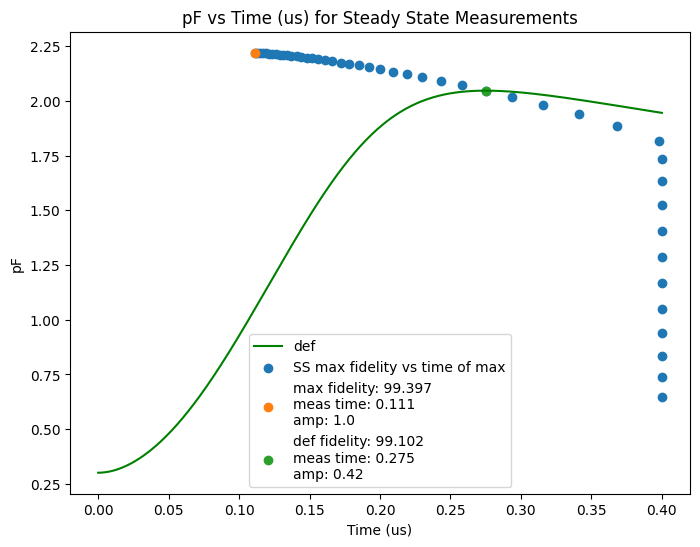

In [41]:
plt.figure(figsize=(8., 6.))
default_amp_ind = jnp.argmin(jnp.abs(amp_linspace - amp_default))
ss_fidelites = 1. - 10**(-batched_max_fidelity)

plt.plot(ts, batched_pF_res[default_amp_ind], label='def', color='green')
plt.scatter(batched_times, batched_max_fidelity, label='SS max fidelity vs time of max')
plt.scatter(
    batched_times[jnp.argmax(batched_max_fidelity)], 
    jnp.max(batched_max_fidelity), 
    label=f'max fidelity: {int(1e5*jnp.max(ss_fidelites)) / 1e3}\nmeas time: {int(1e3*batched_times[jnp.argmax(batched_max_fidelity)]) / 1e3}\namp: {int(1e3*amp_linspace[jnp.argmax(batched_max_fidelity)])/1e3}')
plt.scatter(
    batched_times[default_amp_ind], 
    batched_max_fidelity[default_amp_ind], 
    label=f'def fidelity: {int(1e5*jnp.max(ss_fidelites[default_amp_ind])) / 1e3}\nmeas time: {int(1e3*batched_times[default_amp_ind]) / 1e3}\namp: {int(1e3*amp_linspace[default_amp_ind])/1e3}')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time (us) for Steady State Measurements')
plt.legend()
plt.show()